<a href="https://colab.research.google.com/github/Anshuman-37/Summer_Dissertation/blob/main/Registered_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# ## On Average Takes around 12 minutes 
import os

# !sudo apt -qq install file
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
# !python2 fslinstaller.py
 
fslpath = "/usr/local/fsl"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

!flirt -version 

FLIRT version 6.0


In [ ]:
## Takes a bit time to read the kaggle . json file 
!pip install kaggle --upgrade
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir content/data
!kaggle datasets download -d lyfeisgood/something
!unzip /content/something.zip -d data
!pip install regtricks
!pip install torchsummary

In [39]:
import os
import re
import nibabel as nib
import numpy as np
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch
import regtricks
## Import my .py file ....... 
import Data_Loader as dl
import Models as model
import regtricks as rt

from torchsummary import summary

1.12.0+cu113
True


In [40]:
## Take around 5 minutes
## Defining the path of the data 
x,y = dl.data_loader('/content/data','/content/data',device)

## Printing the shape of specifid data
print('\nShape of MRI images - >');     dl.print_data_shape(x); 
print('\nShape of ASL images - >');     dl.print_data_shape(y);

## Printing the Stats of the data
print('\nStats for MRI data(X) - >');   dl.tensor_stats(x); 
print('\nStats for ASL data(X) - >');   dl.tensor_stats(y);

## Printing the Dimension of X and Y  
## Dimension refer -> Number x Length x Breadth x Height x Channel
print('\nDimensions of X(MRI Data) ->',end=' '); dl.print_data_dimension(x)
print('\nDimensions of Y(ASL Data) ->',end=' '); dl.print_data_dimension(y)


Shape of MRI images - >
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])

Shape of ASL images - >
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])

Stats for MRI data(X) - >
tensor(70232.4141) tensor(0.) tensor(0.0778) tensor(0.1568)
tensor(69193.1094) tensor(0.) tensor(0.0767) tensor(0.1362)
tensor(57976.9219) tensor(0.) tensor(0.0642) tensor(0.1260)
tensor(67808.2734) tensor(0.) tensor(0.0751) tensor(0.1417)
tensor(63041.9375) tensor(0.) tensor(0.0698) tensor(0.1217)
tensor(75418.3359) tensor(0.) tensor(0.0836

In [42]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, LazyConv3d , MaxPool3d, Module, Softmax, BatchNorm3d, Dropout, Conv3d, MSELoss,functional 
from torch.optim import Adam, SGD
from torchsummary import summary as tfsum 
from tqdm import tqdm
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (3,3,2), padding=(1,1,1)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
hidden_2 = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (3,3,5),padding=(1,1,1)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
Hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (1,1,4)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
class Model_1(Module):
    '''Class for the Model to be fitted on MRI data'''
    def __init__(self, c):
        '''Intiallizing the layers of the Model'''
        super(Model_1, self).__init__();
        self.hidden1 = hidden(1,4*c);
        self.hidden2 = hidden(4*c,8*c);
        self.hidden3 = hidden(8*c,16*c);
        self.hidden4 = hidden(16*c,8*c);
        self.hidden5 = hidden(8*c, 16*c);
        self.hidden6 = hidden_2(16*c,8*c);
        self.hidden7 = Hidden(8*c,1);
    def forward(self, x):
        '''Implements the forward pass of the Network'''
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.hidden7(x)
        return x 

In [43]:
channels = 3; #3 Defining the number od channels we have for neural network
# Intializing model
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
model = Model_1(channels).to(device) # Intializing the model 
summary(model,(1, 91,109,91))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 12, 91, 109, 92]             228
       BatchNorm3d-2      [-1, 12, 91, 109, 92]              24
              ReLU-3      [-1, 12, 91, 109, 92]               0
         MaxPool3d-4      [-1, 12, 91, 109, 92]               0
            Conv3d-5      [-1, 24, 91, 109, 93]           5,208
       BatchNorm3d-6      [-1, 24, 91, 109, 93]              48
              ReLU-7      [-1, 24, 91, 109, 93]               0
         MaxPool3d-8      [-1, 24, 91, 109, 93]               0
            Conv3d-9      [-1, 48, 91, 109, 94]          20,784
      BatchNorm3d-10      [-1, 48, 91, 109, 94]              96
             ReLU-11      [-1, 48, 91, 109, 94]               0
        MaxPool3d-12      [-1, 48, 91, 109, 94]               0
           Conv3d-13      [-1, 24, 91, 109, 95]          20,760
      BatchNorm3d-14      [-1, 24, 91, 

In [44]:
def train(epochs,batch_size,x,y):
        '''To train the neural network and return the losses'''
        ## variables 
        ctr = 0; train_loss = []; f_loss = []; predic = [];

        ## Model criterion
        lossFn = MSELoss(); opt = Adam(model.parameters(), lr=1e-5);
        X = x.to(device); Y = y.to(device); model.train();

        ## Loop around the model
        for e in tqdm(range(0, epochs)):
            # Batch Loss and Train Loss 
            batch_loss = []; train_loss = [];
            # Permutation for the data
            permutation = torch.randperm(X.size()[0])
            ctr = ctr + 1;
            ## Loop over batches 
            for i in range(0,X.size()[0], batch_size):
                ## Intialize the optimizer
                opt.zero_grad();
                ## Setting up the indexes for batch
                indices = permutation[i:i+batch_size];
                batch_x, batch_y = X[indices], Y[indices];
                ## Making prediction and Observing the loss
                pred = model(batch_x) ; loss = lossFn(pred, batch_y);
                ##  Update the loss using gradient descent
                loss.backward(); opt.step();
                ## Saving the loss on cpu rather than gpu to optimize memory
                batch_loss.append(loss.cpu().detach().numpy()); 
                if ctr == epochs - 1 : predic.append(pred)
                ## Deleting the batch variables to optimize memoery
                del batch_x , batch_y; 
                ## Deleting the loss and the predictions made 
                del loss , pred;
            train_loss.append(batch_loss);
            ## Printing the verbose
            if(e%10 == 0): 
                print(batch_loss[-1]); print((torch.cuda.memory_allocated())/(1024*1024))
        ## Freeing up GPU memory
        del X,Y;
        return train_loss,predic
train_loss,predic = train(500,4,x,y);
X = x.to(device)

  0%|          | 1/500 [00:14<2:00:22, 14.47s/it]

0.7003613
174.8212890625


  2%|▏         | 11/500 [00:47<27:24,  3.36s/it]

0.1918397
174.8212890625


  4%|▍         | 21/500 [01:19<26:05,  3.27s/it]

0.14797927
174.8212890625


  6%|▌         | 31/500 [01:52<25:31,  3.27s/it]

0.1093502
174.8212890625


  8%|▊         | 41/500 [02:25<25:00,  3.27s/it]

0.08091025
174.8212890625


 10%|█         | 51/500 [02:57<24:26,  3.27s/it]

0.056008514
174.8212890625


 12%|█▏        | 61/500 [03:30<23:53,  3.27s/it]

0.04274824
174.8212890625


 14%|█▍        | 71/500 [04:03<23:21,  3.27s/it]

0.04669013
174.8212890625


 16%|█▌        | 81/500 [04:35<22:48,  3.27s/it]

0.029988112
174.8212890625


 18%|█▊        | 91/500 [05:08<22:15,  3.27s/it]

0.028385727
174.8212890625


 20%|██        | 101/500 [05:41<21:42,  3.27s/it]

0.031852998
174.8212890625


 22%|██▏       | 111/500 [06:13<21:10,  3.27s/it]

0.022080498
174.8212890625


 24%|██▍       | 121/500 [06:46<20:38,  3.27s/it]

0.021236163
174.8212890625


 26%|██▌       | 131/500 [07:19<20:04,  3.26s/it]

0.019217925
174.8212890625


 28%|██▊       | 141/500 [07:51<19:31,  3.26s/it]

0.01846373
174.8212890625


 30%|███       | 151/500 [08:24<18:59,  3.27s/it]

0.016183212
174.8212890625


 32%|███▏      | 161/500 [08:57<18:27,  3.27s/it]

0.014140193
174.8212890625


 34%|███▍      | 171/500 [09:29<17:54,  3.27s/it]

0.017496364
174.8212890625


 36%|███▌      | 181/500 [10:02<17:21,  3.27s/it]

0.012267464
174.8212890625


 38%|███▊      | 191/500 [10:35<16:49,  3.27s/it]

0.011620299
174.8212890625


 40%|████      | 201/500 [11:07<16:16,  3.27s/it]

0.013480464
174.8212890625


 42%|████▏     | 211/500 [11:40<15:43,  3.27s/it]

0.010884942
174.8212890625


 44%|████▍     | 221/500 [12:13<15:11,  3.27s/it]

0.011265525
174.8212890625


 46%|████▌     | 231/500 [12:45<14:38,  3.27s/it]

0.010027668
174.8212890625


 48%|████▊     | 241/500 [13:18<14:05,  3.26s/it]

0.009728484
174.8212890625


 50%|█████     | 251/500 [13:50<13:32,  3.26s/it]

0.008958821
174.8212890625


 52%|█████▏    | 261/500 [14:23<13:00,  3.27s/it]

0.009354271
174.8212890625


 54%|█████▍    | 271/500 [14:56<12:27,  3.27s/it]

0.007890839
174.8212890625


 56%|█████▌    | 281/500 [15:28<11:55,  3.27s/it]

0.008626574
174.8212890625


 58%|█████▊    | 291/500 [16:01<11:22,  3.26s/it]

0.008131427
174.8212890625


 60%|██████    | 301/500 [16:34<10:49,  3.27s/it]

0.008868469
174.8212890625


 62%|██████▏   | 311/500 [17:06<10:17,  3.27s/it]

0.010682654
174.8212890625


 64%|██████▍   | 321/500 [17:39<09:44,  3.27s/it]

0.007806177
174.8212890625


 66%|██████▌   | 331/500 [18:12<09:11,  3.27s/it]

0.009076525
174.8212890625


 68%|██████▊   | 341/500 [18:44<08:39,  3.27s/it]

0.008867306
174.8212890625


 70%|███████   | 351/500 [19:17<08:06,  3.27s/it]

0.006163434
174.8212890625


 72%|███████▏  | 361/500 [19:50<07:33,  3.27s/it]

0.007884464
174.8212890625


 74%|███████▍  | 371/500 [20:22<07:01,  3.27s/it]

0.007013123
174.8212890625


 76%|███████▌  | 381/500 [20:55<06:28,  3.27s/it]

0.008040922
174.8212890625


 78%|███████▊  | 391/500 [21:28<05:55,  3.27s/it]

0.007451623
174.8212890625


 80%|████████  | 401/500 [22:00<05:23,  3.27s/it]

0.0064129853
174.8212890625


 82%|████████▏ | 411/500 [22:33<04:50,  3.27s/it]

0.0064086285
174.8212890625


 84%|████████▍ | 421/500 [23:06<04:18,  3.27s/it]

0.005105892
174.8212890625


 86%|████████▌ | 431/500 [23:38<03:45,  3.27s/it]

0.0072558788
174.8212890625


 88%|████████▊ | 441/500 [24:11<03:12,  3.27s/it]

0.0095571615
174.8212890625


 90%|█████████ | 451/500 [24:44<02:40,  3.27s/it]

0.0047866073
174.8212890625


 92%|█████████▏| 461/500 [25:16<02:07,  3.27s/it]

0.006553563
174.8212890625


 94%|█████████▍| 471/500 [25:49<01:34,  3.27s/it]

0.008961793
174.8212890625


 96%|█████████▌| 481/500 [26:22<01:02,  3.27s/it]

0.0054200683
174.8212890625


 98%|█████████▊| 491/500 [26:54<00:29,  3.27s/it]

0.008344958
174.8212890625


100%|██████████| 500/500 [27:24<00:00,  3.29s/it]


In [45]:
# del model
# print(predic)
print((torch.cuda.memory_allocated())/(1024*1024));
!nvidia-smi

118.40771484375
Wed Jul 27 16:07:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |  15715MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

In [37]:
torch.cuda.empty_cache()
dl.print_data_shape(predic[0])

torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])
torch.Size([1, 91, 109, 91])


(1, 91, 109, 91)
<class 'numpy.ndarray'>


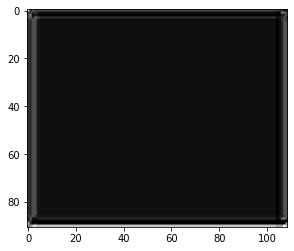

In [46]:
x_first = predic[0][0]
pred_np = x_first.cpu().detach().numpy()
dl.print_data_dimension(pred_np); print(type(pred_np))

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(0,x.shape[4]):
    ## For L2 Distance
    frames.append([plt.imshow(pred_np[0,:,:,i], cmap=cm.Greys_r,animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)
ani.save('movie.mp4')


In [47]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [12]:

#train_loss,prediction = train(2,3,train_x,train_y);



NameError: ignored